<h2 id='part1'>Project 1: Blog</h2>
Looking into the population of the stack Overflow data, I wanted to look at the difference in the population between men and women.

__The questions that I want to answer are:__
<br> a) How does pay differ between men and women?
<br> b) What are the drivers for the differences in pay?
<br> c) From the data, are there strong personal p we use it to predict salary?
 
 
 
 
 Licence info:
This database - The Public 2018 Stack Overflow Developer Survey Results - is made available under the Open Database License (ODbL): http://opendatacommons.org/licenses/odbl/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: http://opendatacommons.org/licenses/dbcl/1.0/


In [1]:
#importing pakcages and reading in data from multiple sources

import numpy as np
import pandas as pd

import os
#from statistics import mean

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

file_path = os.path.join(os.getcwd(),r"StackOverflow_Data\2018\survey_results_public.csv")

df=pd.read_csv(file_path)

#Selecting columns used for the analysis  
cols = ['CareerSatisfaction','JobSatisfaction','Respondent',
        'Country','LanguageWorkedWith','Gender','SexualOrientation',
        'EducationParents','RaceEthnicity','Age','ConvertedSalary',
        'UndergradMajor','FormalEducation','YearsCoding','Dependents']


df_personal = df[cols]


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Question 1: How does pay differ between men and women?

In [2]:
#Output for first Display
def split_and_stack(df_orig, col, sep):
    
    """This splits multiple choice answers within a column into multiple columns, then converts them into extra rows
    so that the popultion can be analysed.
    
    Steps:
    1) Splits a single column in a dataframe into multiple columns (/levels), using a defined seperator.
    2) Stacks these extra column entries into rows, but shows indexes of extra levels which the data was split over.
    3) Extra levels / generated columns are then dropped.
    4) Renames the last column as the Orignal column name.
    
    Parameters:
    df_orig (pandas.DataFrame): A DataFrame containing columns with multiple choice answers.
    col (string): The column which requires multiple choice answers to be split.
    sep (string): The seperator which the column (col) mentioned above needs to be split over.

    Returns:
    pandas.DataFrame:Returning a DataFrame of the total population with extra rows (multiple for the same index) 
    for multiple choice responses.
    
    """
    new_df = df_orig[col].str.split(sep,expand=True).stack().to_frame().reset_index()
    new_df = new_df.drop(['level_0','level_1'], axis=1)
    new_df.columns = [col]
    
    return new_df



df_gender = split_and_stack(df_personal, 'Gender', ';')

#Grouping by and calculating Gender breakdowns. Groupby deals with null Gender values so these are removed.
gender = df_gender.groupby('Gender')['Gender'].count().sort_values(ascending=False)/len(df_gender)
gender_stats = zip(list(gender.index),list(gender))

#Printing stats in percentage form
for gender in gender_stats:
    print(gender[0] + ": " +"{:.2%}".format(gender[1]))
    


Male: 91.68%
Female: 6.76%
Non-binary, genderqueer, or gender non-conforming: 0.91%
Transgender: 0.65%


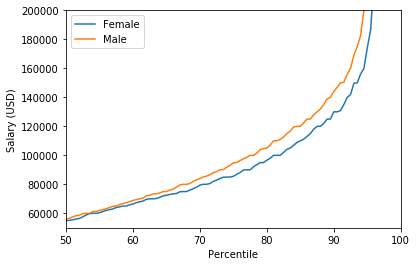

In [5]:
#Output for second display
#Splitting data to male only and female only. 
#Null values for Gender are removed as we don't know their gender and could skew the results.
#Moreover, imputing values wouldn't make sense, we could only use the mode which would jsut be classifying them all as male.
df_male = df_personal.dropna(subset=['Gender'], axis=0)[df_personal.Gender.dropna(axis=0).\
                               apply(lambda x: True if 'Male' in x else False)]

df_female = df_personal.dropna(subset=['Gender'],axis=0)[df_personal.Gender.dropna(axis=0).\
                                 apply(lambda x: True if 'Female' in x else False)]

    
#Finding percentiles of salary for male and female.
#THe Quantile function ignores nulll values for ConvertedSalary. If we imputed values, i.e replace null with mean/median)
#then this would potentially skew the results and change the distribution below.
female_points = [ (i*100, df_female.ConvertedSalary.quantile(i)) for i in np.arange(0,1,0.005) ]
male_points = [ (i*100, df_male.ConvertedSalary.quantile(i)) for i in np.arange(0,1,0.005) ]

x_female = [x[0] for x in female_points]
y_female = [y[1] for y in female_points]

x_male = [x[0] for x in male_points]
y_male = [y[1] for y in male_points]


#setting graph limits x and y limits and labelling axis
plt.ylim((50000,200000))
plt.ylabel('Salary (USD)')
plt.xlabel('Percentile')
plt.xlim((50,100))

plt.plot(x_female, y_female, label = 'Female')
plt.plot(x_male, y_male, label = 'Male')
plt.legend(loc='upper left', prop={'size':10})

#Saving file
plt.savefig(os.path.join(os.getcwd(),'Pay_gap.png'),bbox_inches='tight')

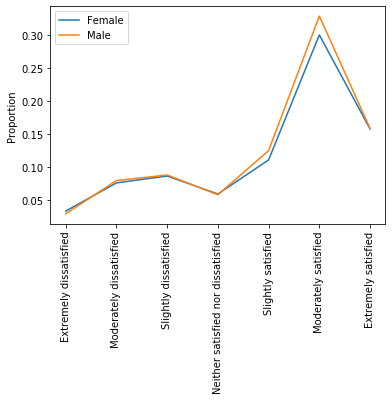

In [6]:
#Output for third display
#Re-casting the CareerSatisfaction to Ordered Category to correctly display in output
df_male['JobSatisfaction']=df_male['JobSatisfaction']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Extremely dissatisfied','Moderately dissatisfied',
                                                        'Slightly dissatisfied','Neither satisfied nor dissatisfied',
                                                        'Slightly satisfied','Moderately satisfied','Extremely satisfied'],
                                            ordered=True))

df_female['JobSatisfaction']=df_female['JobSatisfaction']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Extremely dissatisfied','Moderately dissatisfied',
                                                        'Slightly dissatisfied','Neither satisfied nor dissatisfied',
                                                        'Slightly satisfied','Moderately satisfied','Extremely satisfied'],
                                            ordered=True))

    
#Find percentage breakdown for career satisfaction. Count/Groupby function ignores nulll values for CareerSatisfaction
#Since we just want population distribution, it makes sense to ignore these.
female_points_2 = df_female.groupby('JobSatisfaction').JobSatisfaction.count().sort_index()/len(df_female)
male_points_2 = df_male.groupby('JobSatisfaction').JobSatisfaction.count().sort_index()/len(df_male)

#Formatting and generating a graph
plt.ylabel('Proportion')
plt.xticks(rotation=90)

plt.plot(list(female_points_2.index), list(female_points_2), label = 'Female')
plt.plot(list(male_points_2.index), list(male_points_2), label = 'Male')
plt.legend(loc='upper left', prop={'size':10})

plt.savefig(os.path.join(os.getcwd(),'Gender_job_satisfaction.png'),bbox_inches='tight')

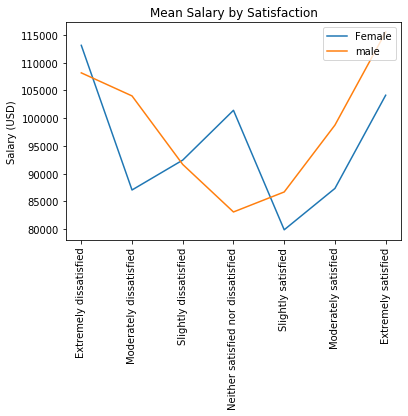

In [7]:
#Find percentage breakdown for career satisfaction. 
#Mean function ignores nulll values for ConvertedSalary. Groupby function ignores nulll values for CareerSatisfaction.
#Since we want mean Salary values, imputing median may skew this figure with large numbers of nulls and mean wouldn't affect this, so ignoring.
#We also want this figure to be consistent with graph above, so not imouting JobSatisfaction values.
female_points_3 = df_female.groupby('JobSatisfaction').ConvertedSalary.mean().sort_index()
male_points_3 = df_male.groupby('JobSatisfaction').ConvertedSalary.mean().sort_index()


#Formatting and generating a graph
plt.title('Mean Salary by Satisfaction')
plt.ylabel('Salary (USD)')
plt.xticks(rotation=90)

plt.plot(list(female_points_3.index), list(female_points_3), label = 'Female')
plt.plot(list(male_points_3.index), list(male_points_3), label = 'male')

plt.legend(loc='upper right', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_pay_by_Satisfaction.png'),bbox_inches='tight')

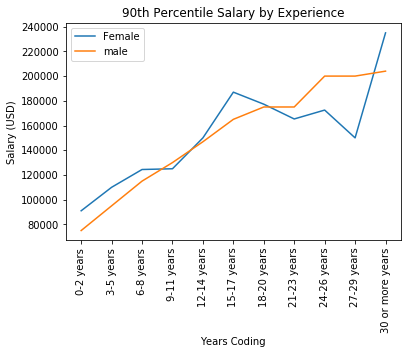

In [8]:
#Calculating 90th percentile salaries by years of experience,  
#Groupby function ignores null values in YearsCoding, quantile function ignores nulll values for ConvertedSalary
#If we imputed the converted salary values, this may shift the distribution, so these are ignored.
#Years coding is directly related with age and it may be non-sensical to impute values as this relation wouldnt be preserved.
female_points_4 = df_female.groupby('YearsCoding').ConvertedSalary.quantile(0.9)
male_points_4 = df_male.groupby('YearsCoding').ConvertedSalary.quantile(0.9)

female_sort_3 = sorted(list(zip(female_points_4.index, female_points_4)),key = lambda x: int(x[0].split()[0].split('-')[0]))
male_sort_3 = sorted(list(zip(male_points_4.index, male_points_4)),key = lambda x: int(x[0].split()[0].split('-')[0]))

x_female_4 = [x[0] for x in female_sort_3]
y_female_4 = [y[1] for y in female_sort_3]
x_male_4 = [x[0] for x in male_sort_3]
y_male_4 = [y[1] for y in male_sort_3]

#Formatting and generating a graph
plt.title('90th Percentile Salary by Experience')
plt.ylabel('Salary (USD)')
plt.xlabel('Years Coding')
plt.xticks(rotation=90)

plt.plot(x_female_4, y_female_4, label = 'Female')
plt.plot(x_male_4, y_male_4, label = 'male')

plt.legend(loc='upper left', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_pay_gap_exp.png'),bbox_inches='tight')


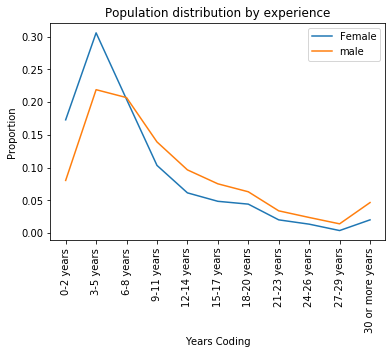

In [9]:
#Calculating population distribution by years of experience. 
#Count & Groupby ignores null values in YearsCoding
#YearsCoding is directly correlated with age, so imputing values will not preserve this relationship
female_points_5 = df_female.groupby('YearsCoding').YearsCoding.count()/len(df_female)
male_points_5 = df_male.groupby('YearsCoding').YearsCoding.count()/len(df_male)

female_sort_4 = sorted(list(zip(female_points_5.index, female_points_5)),key = lambda x: int(x[0].split()[0].split('-')[0]))
male_sort_4 = sorted(list(zip(male_points_5.index, male_points_5)),key = lambda x: int(x[0].split()[0].split('-')[0]))

x_female_5 = [x[0] for x in female_sort_4]
y_female_5 = [y[1] for y in female_sort_4]
x_male_5 = [x[0] for x in male_sort_4]
y_male_5 = [y[1] for y in male_sort_4]

#Formatting and generating a graph
plt.title('Population distribution by experience')
plt.ylabel('Proportion')
plt.xlabel('Years Coding')
plt.xticks(rotation=90)

plt.plot(x_female_5, y_female_5, label = 'Female')
plt.plot(x_male_5, y_male_5, label = 'male')

plt.legend(loc='upper right', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_exp_pop_dist.png'),bbox_inches='tight')


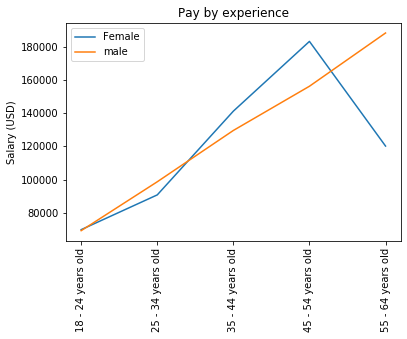

In [9]:
working_professionals = ['18 - 24 years old','25 - 34 years old','35 - 44 years old',
                         '45 - 54 years old','55 - 64 years old']

#Calculating population distribution by years of experience. 
#Count function ignores nulll values for ConvertedSalary, Groupby ignores null values in YearsCoding
female_points_6 = df_female.groupby('Age').ConvertedSalary.mean()[working_professionals]
male_points_6 = df_male.groupby('Age').ConvertedSalary.mean()[working_professionals]

female_sort_5 = list(zip(female_points_6.index, female_points_6))#,key = lambda x: int(x[0].split()[0].split('-')[0]))
male_sort_5 = list(zip(male_points_6.index, male_points_6))#,key = lambda x: int(x[0].split()[0].split('-')[0]))

x_female_6 = [x[0] for x in female_sort_5]
y_female_6 = [y[1] for y in female_sort_5]
x_male_6 = [x[0] for x in male_sort_5]
y_male_6 = [y[1] for y in male_sort_5]

plt.title('Pay by experience')
plt.ylabel('Salary (USD)')
plt.xticks(rotation=90)

plt.plot(x_female_6, y_female_6, label = 'Female')
plt.plot(x_male_6, y_male_6, label = 'male')

plt.legend(loc='upper left', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Pay_by_age.png'),bbox_inches='tight')

<h2 id='part1'>Question 2: Why are there differences in the demographics of men and women?</h2>
    
    

In [11]:
#We are only interested in looking at population who answered the dependency question and the salary question.
#Therefore, dropping values where people haven't answered these questions as it won't inform outcome
df_dep_no_null_f = df_female.dropna(subset=['Dependents','ConvertedSalary'],how='any')
df_dep_no_null_m = df_male.dropna(subset=['Dependents','ConvertedSalary'],how='any')

#Filtering for ages most likley children are to have an impact on salary.
#Women tend to retire earlier than men and under 25s are unlikely to have children, potentially not have a slary either.
#Therefore, they have been removed
ages_for_children = ['25 - 34 years old','35 - 44 years old','45 - 54 years old']

df_dependents_f=df_dep_no_null_f[df_dep_no_null_f.Age.apply(lambda x: True if x in ages_for_children else False)]
df_dependents_m=df_dep_no_null_m[df_dep_no_null_m.Age.apply(lambda x: True if x in ages_for_children else False)]

#Finding average Salaries by age and by dependents status
#Groupby removes nulls for Age, since we want to find out affects over age bands, these values have been dropped.
female_series = df_dependents_f.groupby(['Dependents','Age']).ConvertedSalary.mean()
male_series = df_dependents_m.groupby(['Dependents','Age']).ConvertedSalary.mean()

#Calculating the relative mean gain/loss
female_dep_cost = female_series['No']/female_series['Yes']
male_dep_cost = male_series['No']/male_series['Yes']


df_dep_cost = pd.concat([pd.DataFrame(list(female_dep_cost), index = list(female_dep_cost.index), columns = ['Female']),
                        pd.DataFrame(list(male_dep_cost), index = list(male_dep_cost.index),columns=['Male'])],axis=1)
df_dep_cost['Female'] = df_dep_cost['Female'].apply(lambda x: "{:.2%}".format(x-1))
df_dep_cost['Male'] = df_dep_cost['Male'].apply(lambda x: "{:.2%}".format(x-1))

df_dep_cost

,Female,Male
25 - 34 years old,12.96%,1.86%
35 - 44 years old,3.15%,-3.53%
45 - 54 years old,17.83%,3.93%


In [12]:
#Calculating total proportion of Computer Science related degrees for each gender
technical_degree = ['Computer science, computer engineering, or software engineering',
                   'Information systems, information technology, or system administration'
                   'Web development or web design']

#Dropping entries with NaNs for undergrad major, otherwise we would be assuming they were 'Non-Technical'
#for all nulls in the population which would skew the results. Moreover, removing nulls also removes those who didn't
#go to university. Since we are considering those with technical degrees, we want to remove these people from our population
df_female_grad = df_female.dropna(subset=['UndergradMajor'],axis=0)
df_male_grad = df_male.dropna(subset=['UndergradMajor'],axis=0)

df_female_grad['TechnicalDegree'] = df_female_grad.UndergradMajor\
                                    .apply(lambda x : 'Technical' if x in technical_degree else 'Non-Technical')
df_male_grad['TechnicalDegree'] = df_male_grad.UndergradMajor\
                                    .apply(lambda x : 'Technical' if x in technical_degree else 'Non-Technical')

female_tech_bd = df_female_grad.groupby('TechnicalDegree').TechnicalDegree.count()/len(df_female_grad)
male_tech_bd = df_male_grad.groupby('TechnicalDegree').TechnicalDegree.count()/len(df_male_grad)

print('Women with a Computer Science related degree: ' + "{:.2%}".format(female_tech_bd['Technical']))
print('Men with a Computer Science related degree: ' + "{:.2%}".format(male_tech_bd['Technical']))


Women with a Computer Science related degree: 54.19%
Men with a Computer Science related degree: 63.84%


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
#Filtering list to only Technical people to show age distribution of this
df_female_tech = df_female_grad[df_female_grad['TechnicalDegree']=='Technical']
df_male_tech = df_male_grad[df_male_grad['TechnicalDegree']=='Technical']

over_35 = ['35 - 44 years old','45 - 54 years old','55 - 64 years old','65 years or older']
under_25 = ['25 - 34 years old','18 - 24 years old']

#Groupby removes nulls for Age, since we want to find out effects over age bands, these values have been dropped.
female_tech_bd_age = df_female_tech.groupby('Age')['Age'].count()/len(df_female_tech)
male_tech_bd_age = df_male_tech.groupby('Age')['Age'].count()/len(df_male_tech)

##Only showing working age people, as these are the ones likely to have a degree
print('Women, 35 and over: ' + "{:.2%}".format(female_tech_bd_age[over_35].sum()))
print('Men, 35 and over: ' + "{:.2%}".format(male_tech_bd_age[over_35].sum()))
print('Women, 18 to 25: ' + "{:.2%}".format(female_tech_bd_age[under_25].sum()))
print('Men, 18 to 25: ' + "{:.2%}".format(male_tech_bd_age[under_25].sum()))

Women, 35 and over: 14.92%
Men, 35 and over: 23.03%
Women, 18 to 25: 82.15%
Men, 18 to 25: 75.21%


In [17]:
#FInding the split of STEM graduates in the population
non_STEM = ['Fine arts or performing arts (ex. graphic design, music, studio art)',
            'A social science (ex. anthropology, psychology, political science)',
            'A humanities discipline (ex. literature, history, philosophy)',
            'A business discipline (ex. accounting, finance, marketing)',
            'I never declared a major']

df_female_grad['STEM'] = df_female_grad.UndergradMajor\
                                    .apply(lambda x : 'Non-STEM' if x in non_STEM else 'STEM')
df_male_grad['STEM'] = df_male_grad.UndergradMajor\
                                    .apply(lambda x : 'Non-STEM' if x in non_STEM else 'STEM')

print("Women in STEM: {:.2%}".format(df_female_grad.groupby('STEM').STEM.count()['STEM']/len(df_female_grad)))
print("Men in STEM: {:.2%}".format(df_male_grad.groupby('STEM').STEM.count()['STEM']/len(df_male_grad)))

Women in STEM: 82.32%
Men in STEM: 91.66%


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [18]:
#Filtering out stem graduates only and looking at distribution of stem graduates by age and gender.
df_female_STEM = df_female_grad[df_female_grad['STEM']=='STEM']
df_male_STEM = df_male_grad[df_male_grad['STEM']=='STEM']

#Only considering working professionals as they are most likely to have degrees and be in employment
working_professionals = ['18 - 24 years old','25 - 34 years old','35 - 44 years old',
                         '45 - 54 years old','55 - 64 years old']

#Groupby removes nulls for Age, since we want to find out affects over age bands, these values have been dropped.
female_STEM_bd_age = df_female_STEM.groupby('Age')['Age'].count()[working_professionals]/len(df_female_STEM)
male_STEM_bd_age = df_male_STEM.groupby('Age')['Age'].count()[working_professionals]/len(df_male_STEM)

#Combining data together into one DataFrame
df_STEM_bd = pd.concat([pd.DataFrame(list(female_STEM_bd_age), index = list(female_STEM_bd_age.index), columns = ['Female']),
                        pd.DataFrame(list(male_STEM_bd_age), index = list(male_STEM_bd_age.index),columns=['Male'])],axis=1)

#Reformatting data into percentages to 2dp.
df_STEM_bd['Female'] = df_STEM_bd['Female'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd['Male'] = df_STEM_bd['Male'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd

,Female,Male
18 - 24 years old,26.73%,20.62%
25 - 34 years old,53.18%,52.50%
35 - 44 years old,12.73%,18.32%
45 - 54 years old,3.36%,5.12%
55 - 64 years old,1.11%,1.44%


In [19]:
#Calculating the STEM percentage for __EACH__ age group, by gender
#Groupby removes nulls for Age, since we want to find out affects over age bands, these values have been dropped.
STEM_count_f = df_female_grad.groupby(['STEM','Age']).STEM.count()['STEM'][working_professionals]
STEM_count_f_total = df_female_grad.groupby('Age').STEM.count()[working_professionals]

STEM_count_m = df_male_grad.groupby(['STEM','Age']).STEM.count()['STEM'][working_professionals]
STEM_count_m_total = df_male_grad.groupby('Age').STEM.count()[working_professionals]

STEM_bd_female = STEM_count_f/STEM_count_f_total
STEM_bd_male = STEM_count_m/STEM_count_m_total


#Combining data together into one DataFrame
df_STEM_bd_2 = pd.concat([pd.DataFrame(list(STEM_bd_female), index = list(STEM_bd_female.index), columns = ['Female']),
                        pd.DataFrame(list(STEM_bd_male), index = list(STEM_bd_male.index),columns=['Male'])],axis=1)

#Reformatting data into percentages to 2dp.
df_STEM_bd_2['Female'] = df_STEM_bd_2['Female'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd_2['Male'] = df_STEM_bd_2['Male'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd_2

,Female,Male
18 - 24 years old,93.36%,96.33%
25 - 34 years old,79.99%,92.02%
35 - 44 years old,76.14%,87.93%
45 - 54 years old,70.20%,86.21%
55 - 64 years old,74.47%,85.35%


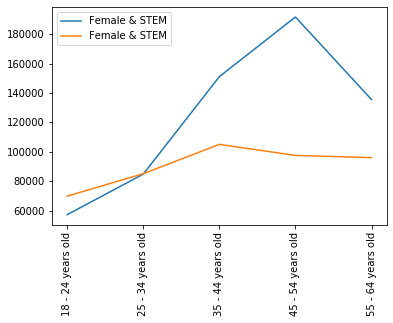

In [22]:
#Groupby removes nulls for Age, since we want to find out affects over age bands, these values have been dropped.
df_STEM_age_f = df_female_grad.groupby(['STEM','Age']).ConvertedSalary.mean()['STEM'][working_professionals]
df_NSTEM_age_f = df_female_grad.groupby(['STEM','Age']).ConvertedSalary.mean()['Non-STEM'][working_professionals]

plt.plot(list(df_STEM_age_f.index),list(df_STEM_age_f), label='Female & STEM')
plt.plot(list(df_NSTEM_age_f.index),list(df_NSTEM_age_f), label='Female & STEM')
plt.xticks(rotation=90)
plt.legend()
#df_female_grad.groupby(['STEM','Age']).ConvertedSalary.mean()[working_professionals]

<h2 id='part1'>Question 3, Are the... ?</h2>
 

In [275]:
new_df = df[['Age','Country','LanguageWorkedWith','ConvertedSalary','Dependents','CompanySize']]

new_df['CompanySize']=new_df['CompanySize']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Fewer than 10 employees','10 to 19 employees',
                                                        '20 to 99 employees','100 to 499 employees',
                                                        '500 to 999 employees','1,000 to 4,999 employees',
                                                        '5,000 to 9,999 employees','10,000 or more employees'],
                                            ordered=True))

new_df=new_df.dropna()
new_df['Age']= new_df['Age'].apply(lambda x: np.nan if x.split()[0] in ['Under','65'] else (int(x.split()[0]) + int(x.split()[2]))/2)
new_df=new_df.dropna()

values_to_index = list(new_df.groupby('CompanySize').CompanySize.count().sort_index().index)
new_df['CompanySize']= new_df['CompanySize'].apply(lambda x : values_to_index.index(x) if pd.isna(x) == False else x) # feature_columns(new_df,'JobSatisfaction')
new_df['Dependents']= new_df['Dependents'].apply(lambda x: 1 if x == 'Yes' in ['Under','65'] else 0)
new_df = feature_columns(new_df,'LanguageWorkedWith',';')
new_df = feature_columns(new_df,'Country')

C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [279]:
X = new_df.drop(['ConvertedSalary'],axis=1)
y = new_df['ConvertedSalary']


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

clf=RandomForestRegressor(n_estimators=100)
clf.fit(X_train,y_train)

y_pred_test=clf.predict(X_test)
y_pred_train=clf.predict(X_train)

print("Test score: ",r2_score(y_test, y_pred_test))
print("Train score: ",r2_score(y_train, y_pred_train))
sorted(list(zip(X.columns,clf.feature_importances_)),key = lambda x:x[1],reverse=True)



Test score:  0.03479958500026448
Train score:  0.1142638919286495


[('CompanySize', 0.2850276878083212),
 ('United States', 0.23278847534809366),
 ('Age', 0.13974186010074752),
 ('United Kingdom', 0.03725341785365803),
 ('India', 0.01875289513544095),
 ('Ireland', 0.017904791673449327),
 ('Canada', 0.01557202099802857),
 ('Australia', 0.01399739488000308),
 ('Chile', 0.013572040632107273),
 ('Bash/Shell', 0.013567420039415308),
 ('Python', 0.013486642025865367),
 ('Switzerland', 0.01191875905349882),
 ('C#', 0.011836172843602237),
 ('Germany', 0.010911046497265306),
 ('Norway', 0.009896593016338972),
 ('France', 0.0082992036987758),
 ('Java', 0.007457331976985237),
 ('Objective-C', 0.007430245558927601),
 ('SQL', 0.006619414993421282),
 ('Italy', 0.006397139187969833),
 ('Venezuela, Bolivarian Republic of...', 0.006206152780062503),
 ('New Zealand', 0.006017605936357739),
 ('Spain', 0.0058663369461646984),
 ('Netherlands', 0.005071292994780754),
 ('Swift', 0.0050333249741969),
 ('South Korea', 0.004984381706880063),
 ('PHP', 0.004658890719282346),
 ('

In [249]:
other_cols = [col for col in new_df.columns if col not in mapping_category.values()]

new_df = pd.concat([new_df[mapping_category.values()].apply(lambda col: col.fillna(col.mode()[0]),axis=0),
                    new_df[other_cols]], axis =1)
from sklearn.ensemble import RandomForestClassifier
X = new_df.drop(['Age'],axis=1)
y = new_df['Age']


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

clf=RandomForestRegressor(n_estimators=100)
clf.fit(X_train,y_train)

y_pred_test=clf.predict(X_test)
y_pred_train=clf.predict(X_train)

print("Test score: ",r2_score(y_test, y_pred_test))
print("Train score: ",r2_score(y_train, y_pred_train))
list(zip(X.columns,clf.feature_importances_))

Test score:  0.224107885889253
Train score:  0.8915185968011656


NameError: name 'x' is not defined

In [103]:
def feature_columns(df_orig, col, sep = None):
    
    if sep is None:
        unique_values = list(df_orig[col].unique())
    else:
        unique_values = list(split_and_stack(df_orig,col,sep)[col].unique())
    
    for value in unique_values:
        df_orig[value] = df_orig[col].apply(lambda x : 1 if x in unique_values else 0)
    
    df_orig = df_orig.drop([col], axis=1)
    
    return df
        

df_no_na=df.dropna().drop(['Respondent'], axis=1)
df_no_na['YearsCoding']=df_no_na['YearsCoding'].apply(lambda x : sum([float(y) for y in x.split()[0].split('-')])/2)
df_no_na['Age']= df_no_na['Age'].apply(lambda x: np.nan if x.split()[0] in ['Under','65'] else (int(x.split()[0]) + int(x.split()[2]))/2)
df_no_na=df_no_na.dropna()


X=df_no_na.drop(['ConvertedSalary'], axis=1)
y=df_no_na['ConvertedSalary']

multiple_choice_cols = ['LanguageWorkedWith','Gender','SexualOrientation','RaceEthnicity']
    
for col in df.select_dtypes(include=['object','category']).columns: 
    if col in multiple_choice_cols:      
        X = feature_columns(X,col, ';')
        
    else:       
        X = feature_columns(X,col)



X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.,random_state=42)

In [104]:
reg=RandomForestRegressor()
reg.fit(X_train,y_train)

y_pred_test= reg.predict(X_test)
y_pred_train= reg.predict(X_train)

print("Test score: ",r2_score(y_test, y_pred_test))
print("Train score: ",r2_score(y_train, y_pred_train))
list(zip(X_train.columns,reg.feature_importances_))

Test score:  -0.9440583232077762
Train score:  0.853877755511022


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[('AssessJob1', 0.2222222222222222),
 ('AssessJob2', 0.016366065464261795),
 ('AssessJob3', 0.0),
 ('AssessJob4', 0.0),
 ('AssessJob5', 0.10292807837898021),
 ('AssessJob6', 0.0),
 ('AssessJob7', 0.1111111111111111),
 ('AssessJob8', 0.008183032732130897),
 ('AssessJob9', 0.0),
 ('AssessJob10', 0.0),
 ('AssessBenefits1', 0.0),
 ('AssessBenefits2', 0.0),
 ('AssessBenefits3', 0.0),
 ('AssessBenefits4', 0.0),
 ('AssessBenefits5', 0.0),
 ('AssessBenefits6', 0.0),
 ('AssessBenefits7', 0.0),
 ('AssessBenefits8', 0.0),
 ('AssessBenefits9', 0.0),
 ('AssessBenefits10', 0.0),
 ('AssessBenefits11', 0.1111111111111111),
 ('JobContactPriorities1', 0.10292807837898021),
 ('JobContactPriorities2', 0.0),
 ('JobContactPriorities3', 0.0),
 ('JobContactPriorities4', 0.0),
 ('JobContactPriorities5', 0.0),
 ('JobEmailPriorities1', 0.0),
 ('JobEmailPriorities2', 0.0),
 ('JobEmailPriorities3', 0.0),
 ('JobEmailPriorities4', 0.0),
 ('JobEmailPriorities5', 0.1111111111111111),
 ('JobEmailPriorities6', 0.1029280

In [91]:
#list(df.columns)
#df_personal.groupby('LanguageWorkedWith')['LanguageWorkedWith'].count().sort_values(ascending=False)/len(df_personal)
df_lww=df_personal['LanguageWorkedWith'].str.split(';',expand=True).stack().to_frame().reset_index()
df_lww=df_lww.drop(['level_0','level_1'], axis=1)
df_lww.columns=['LanguageWorkedWith']
list(df_lww.groupby('LanguageWorkedWith')['LanguageWorkedWith'].count().sort_values(ascending=False).nlargest(5).index)

['JavaScript', 'HTML', 'CSS', 'SQL', 'Java']

In [ ]:
def df_to_index(df, ignore = []):
    
    """Converts all 'object' or 'category' datatype columns in a DataFrame to an integer datatype column by finding the unique entries 
    and assigning an index to each one, creating a new dataframe.
    
    Note: This requires a CLEAN dataset, i.e no null values
    
    Parameters:
    df (pandas.DataFrame): A DataFrame containing the columns you wish to index.
    ignore (List of strings): The columns which you would like to ignore when indexing.

    Returns:
    pandas.DataFrame: Returning a new DataFrame with indexed versions of the original columns.
    
    """
    list(df.dtypes) + ignore
    cols_to_index = list(df.select_dtypes(include=['object','category']).columns)
    
    for col in cols_to_index:
        if col not in ignore:
            new_df = df

            unique_entries = list(new_df[col].unique())

            new_df[col] = new_df[col].apply(lambda x: unique_entries.index(x))
    
    return new_df


df_clean = df_to_index(df_personal.dropna())


In [ ]:
def sort_series(series_1, series_2, key_func):
    """This splits a series into the its indicies and series values, preparing it to be plotted.
    
    Parameters:
    series (pandas.Series): A DataFrame containing columns with multiple choice answers.
    key_func (lambda function): The column which requires multiple choice answers to be split.

    Returns:
    index_points (list): the indices of a series 
    series_points (list): the values within the series
    
    """    
    series_sort_1 = sorted(list(zip(series_1.index, series_1)),key = key_func)
    series_sort_2 = sorted(list(zip(series_2.index, series_2)),key = key_func)
    
    index_points = [x[0] for x in series_sort]
    series_points = [y[1] for y in series_sort]
    
    return index_points, series_points

In [ ]:
mapping_category = {'AssessJob1' : 'Industry', 'AssessJob2' : 'Company Performance', 'AssessJob3' : 'Team',
                    'AssessJob4' : 'Technologies', 'AssessJob5' : 'Compensation', 'AssessJob6' : 'Culture',
                    'AssessJob7' : 'Remote', 'AssessJob8' : 'Opportunities', 'AssessJob9' : 'Diversity',
                    'AssessJob10' : 'ProductReach', 'AssessBenefits1' : 'Salary', 'AssessBenefits2' : 'StockOptions',
                    'AssessBenefits3' : 'Insurance', 'AssessBenefits4' : 'ParentalLeave','AssessBenefits5' : 'Memberships',
                    'AssessBenefits6' : 'Pension', 'AssessBenefits7' : 'FreeFood', 'AssessBenefits8' : 'EquipmentBudget',
                    'AssessBenefits9' : 'Childcare', 'AssessBenefits10' : 'FreeTransport',
                    'AssessBenefits11' : 'EducationBudget'}


def feature_columns(df_orig, col, sep = None):
    
    if sep is None:
        unique_values = list(df_orig[col].unique())
    else:
        unique_values = list(split_and_stack(df_orig,col,sep)[col].unique())
    
    for value in unique_values:
        df_orig[value] = df_orig[col].apply(lambda x : 1 if x ==value else 0)
    
    df_orig = df_orig.drop([col], axis=1)
    
    return df_orig



new_df = df[list(mapping_category.keys())+['Gender','JobSatisfaction','Age','ConvertedSalary']]
new_df = new_df.dropna(subset=['Gender'],axis=0)
new_df['Male']=new_df.Gender.apply(lambda x: 1 if x == 'Male' else 0)
new_df['JobSatisfaction']=new_df['JobSatisfaction']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['10,000 or more employees',
                                                         '10 to 19 employees',
                                                         '100 to 499 employees',
                                                         '20 to 99 employees',
                                                         '1,000 to 4,999 employees',
                                                         '500 to 999 employees',
                                                         '5,000 to 9,999 employees',
                                                         'Fewer than 10 employees']
,
                                            ordered=True))

new_df['JobSatisfaction']=new_df['JobSatisfaction']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Fewer than 10 employees','10 to 19 employees'',
                                                        '20 to 99 employees','100 to 499 employees',
                                                        '500 to 999 employees','1,000 to 4,999 employees',
                                                        '5,000 to 9,999 employees','10,000 or more employees'],
                                            ordered=True))

values_to_index = list(new_df.groupby('JobSatisfaction').JobSatisfaction.count().sort_index().index)
new_df['JobSatisfaction']= new_df['JobSatisfaction'].apply(lambda x : values_to_index.index(x) if pd.isna(x) == False else x) # feature_columns(new_df,'JobSatisfaction')

new_df = new_df.dropna(subset=['ConvertedSalary','Age','JobSatisfaction'],axis=0)
new_df['Age']= new_df['Age'].apply(lambda x: np.nan if x.split()[0] in ['Under','65'] else (int(x.split()[0]) + int(x.split()[2]))/2)
new_df = new_df.dropna(subset=['Age'],axis=0)
new_df = new_df.dropna(subset=list(mapping_category), axis=0, how='all')
new_df = new_df[new_df.Gender.apply(lambda x : False if (';' in x) or x in ['Non-binary, genderqueer, or gender non-conforming', 'Transgender']  else True)]
new_df = new_df.drop(['Gender'],axis=1)
new_df = new_df.rename(mapping_category, axis=1)
new_df.isnull().mean()